In [50]:
import pandas as pd

play_text_df = pd.read_csv("will_play_text.csv", sep=';')
play_text_df.columns = ['index', 'play', 'scene', 'scene2', 'character', 'text']
grouped_text = play_text_df.groupby(by=['play'])

In [51]:
play_names = pd.read_csv("play_names.txt").values.tolist()
play_names = [play[0] for play in play_names]
vocab = pd.read_csv("vocab.txt").values.tolist()
vocab = [v[0] for v in vocab]


In [56]:
grouped_text.get_group('Hamlet')

index    play  scene   scene2          character  \
32431  32433  Hamlet  138.0      NaN          CYMBELINE   
32432  32434  Hamlet  138.0      NaN          CYMBELINE   
32433  32435  Hamlet  138.0      NaN          CYMBELINE   
32434  32436  Hamlet    1.0    1.1.1           BERNARDO   
32435  32437  Hamlet    2.0    1.1.2          FRANCISCO   
...      ...     ...    ...      ...                ...   
36670  36672  Hamlet  147.0  5.2.421  PRINCE FORTINBRAS   
36671  36673  Hamlet  147.0  5.2.422  PRINCE FORTINBRAS   
36672  36674  Hamlet  147.0  5.2.423  PRINCE FORTINBRAS   
36673  36675  Hamlet  147.0  5.2.424  PRINCE FORTINBRAS   
36674  36676  Hamlet  147.0  5.2.424  PRINCE FORTINBRAS   

                                                    text  
32431                                              ACT I  
32432   SCENE I. Elsinore. A platform before the castle.  
32433       FRANCISCO at his post. Enter to him BERNARDO  
32434                                       Who's there?  
32435        Nay, answer me: stand, and unfold yourself.  
...                                                  ...  
36670                              Speak loudly for him.  
36671           Take up the bodies: such a sight as this  
36672      Becomes the field, but here shows much amiss.  
36673                        Go, bid the soldiers shoot.  
36674  A dead march. Exeunt, bearing off the dead bod...  

[4244 rows x 6 columns]

In [59]:
from collections import defaultdict
import spacy
import time

# lowercase and tokenize each play
nlp = spacy.load("en_core_web_sm")

start = time.time()

play_text = defaultdict(str)
for play in play_names:
    texts = list(grouped_text.get_group(play)['text'])
    string = ""
    for text in texts:
        doc = nlp(text.lower())
        for token in doc:
            if not token.is_punct: 
                string += token.text + ' '
    play_text[play] = string
    
    
print("--- %s seconds ---" % (time.time() - start))

--- 612.3717789649963 seconds ---


In [60]:
import json

# save for later use. preprocess takes so much time...
with open('play_text.json', 'w') as f:
    json.dump(play_text, f)

In [42]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=vocab)

In [69]:
term_doc = pd.DataFrame(columns=play_names)
for play in play_names:
    term_doc[play] = vectorizer.fit_transform([play_text[play]]).toarray()[0]
term_doc.index = vectorizer.get_feature_names()

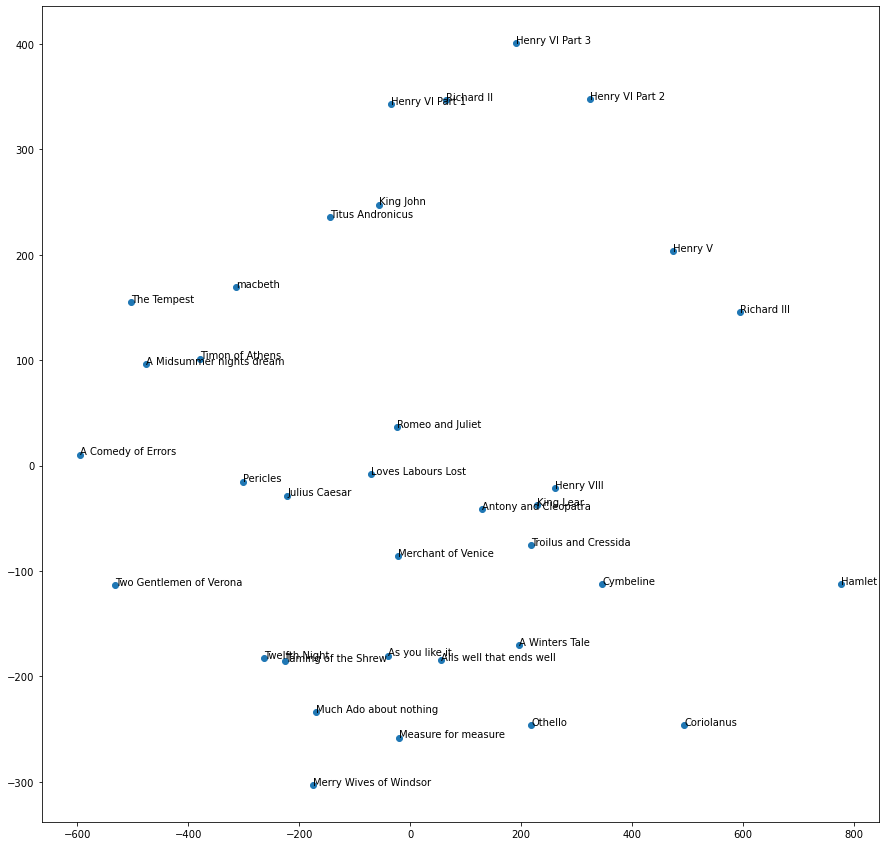

In [88]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
result = pca.fit_transform(term_doc.values.T)
plt.figure(figsize=(15,15))
plt.scatter(result[:, 0], result[:, 1])
for i, play in enumerate(play_names):
	plt.annotate(play, xy=(result[i, 0], result[i, 1]))
plt.show() 

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(vocabulary=vocab)

tfidf_term_doc = pd.DataFrame(columns=play_names)
for play in play_names:
    tfidf_term_doc[play] = tfidf_vectorizer.fit_transform([play_text[play]]).toarray()[0]
tfidf_term_doc.index = tfidf_vectorizer.get_feature_names()

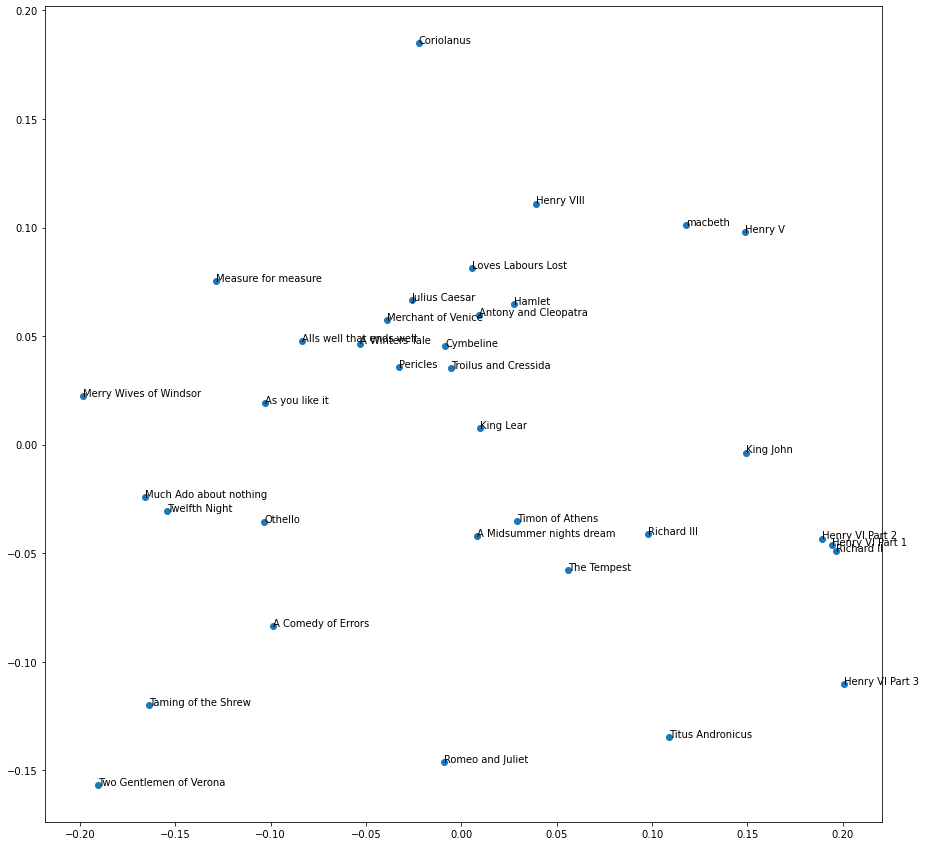

In [91]:
tfidf_result = pca.fit_transform(tfidf_term_doc.values.T)
plt.figure(figsize=(15,15))
plt.scatter(tfidf_result[:, 0], tfidf_result[:, 1])
for i, play in enumerate(play_names):
	plt.annotate(play, xy=(tfidf_result[i, 0], tfidf_result[i, 1]))
plt.show() 

In [99]:
# Q1.8

import re
w2v_docs = defaultdict(list) # str: [["", "", ""], ["", ""] ...]
for play in play_names:
    texts = list(grouped_text.get_group(play)['text'])
    # lower case and remove punctuations
    sents = [re.sub(r'[^\w\s]', '', text).lower().split() for text in texts]
    w2v_docs[play] = sents

In [124]:
from collections import Counter
from gensim.models import Word2Vec
import numpy as np

w2v_plays = defaultdict() # store averaged word vectors for each play
for play in play_names:
    # 1. get vocabulary of each play
    play_vocab = list(Counter(play_text[play].split()).keys())
    w2v_model = Word2Vec(sentences=w2v_docs[play], vector_size=100, min_count=1, workers=4)
    avg_vector = []
    for word in play_vocab:
        try:
            v = w2v_model.wv[word]
            avg_vector.append(v)
        except KeyError: # ignore OOV word
            continue
    avg_vector = np.mean(np.asarray(avg_vector), axis=0)
    w2v_plays[play] = avg_vector

In [132]:
from numpy.linalg import norm

# compute average pairwise cosine similarities for comedies
comedies_plays = ['The Tempest', 'Two Gentlemen of Verona', 'Merry Wives of Windsor', 'Measure for measure',
                 'A Comedy of Errors', 'Much Ado about nothing', 'Loves Labours Lost',  'A Midsummer nights dream',
                 'Merchant of Venice',  'As you like it',  'Taming of the Shrew', 'Alls well that ends well',
                  'Twelfth Night',  'A Winters Tale',  'Pericles']
comedies_pairs = [(a, b) for idx, a in enumerate(comedies_plays) for b in comedies_plays[idx + 1:]]
comedies_cossim = []
for pair in comedies_pairs:
    cossim = w2v_plays[pair[0]] @ w2v_plays[pair[1]] / (norm(w2v_plays[pair[0]]) * norm(w2v_plays[pair[1]]))
    comedies_cossim.append(cossim)

comedies_avg_cossim = np.mean(np.asarray(comedies_cossim), axis=0)
print("comedies_avg_cossim: ", comedies_avg_cossim)

comedies_avg_cossim:  0.945728


In [134]:
# compute average pairwise cosine similarities for comedies
histories_plays = ['King John',  'Richard II', 'Henry VI Part 2', 'Henry VIII',
                  'Henry VI Part 1', 'Henry V',  'Henry VI Part 3',  'Richard III']
histories_pairs = [(a, b) for idx, a in enumerate(histories_plays) for b in histories_plays[idx + 1:]]
histories_cossim = []
for pair in histories_pairs:
    cossim = w2v_plays[pair[0]] @ w2v_plays[pair[1]] / (norm(w2v_plays[pair[0]]) * norm(w2v_plays[pair[1]]))
    histories_cossim.append(cossim)

histories_avg_cossim = np.mean(np.asarray(histories_cossim), axis=0)
print("histories_avg_cossim: ", histories_avg_cossim)

histories_avg_cossim:  0.93888885


In [136]:
# compute average pairwise cosine similarities for comedies
tragedies_plays = [ 'Troilus and Cressida', 'Coriolanus', 'Titus Andronicus',  'Romeo and Juliet',
                   'Timon of Athens', 'Julius Caesar', 'macbeth', 'Hamlet', 'King Lear',
                    'Othello',  'Antony and Cleopatra', 'Cymbeline']
tragedies_pairs = [(a, b) for idx, a in enumerate(tragedies_plays) for b in tragedies_plays[idx + 1:]]
tragedies_cossim = []
for pair in tragedies_pairs:
    cossim = w2v_plays[pair[0]] @ w2v_plays[pair[1]] / (norm(w2v_plays[pair[0]]) * norm(w2v_plays[pair[1]]))
    tragedies_cossim.append(cossim)

tragedies_avg_cossim = np.mean(np.asarray(tragedies_cossim), axis=0)
print("tragedies_avg_cossim: ", tragedies_avg_cossim)

tragedies_avg_cossim:  0.9465048


In [137]:
com_hist_pairs = [(a, b) for a in comedies_plays for b in histories_plays]
com_hist_cossim = []
for pair in com_hist_pairs:
    cossim = w2v_plays[pair[0]] @ w2v_plays[pair[1]] / (norm(w2v_plays[pair[0]]) * norm(w2v_plays[pair[1]]))
    com_hist_cossim.append(cossim)
com_hist_avg_cossim = np.mean(np.asarray(com_hist_cossim), axis=0)
print("com_hist_avg_cossim: ", com_hist_avg_cossim)

com_hist_avg_cossim:  0.9421766


In [140]:
com_trag_pairs = [(a, b) for a in comedies_plays for b in tragedies_plays]
com_trag_cossim = []
for pair in com_trag_pairs:
    cossim = w2v_plays[pair[0]] @ w2v_plays[pair[1]] / (norm(w2v_plays[pair[0]]) * norm(w2v_plays[pair[1]]))
    com_trag_cossim.append(cossim)
com_trag_avg_cossim = np.mean(np.asarray(com_trag_cossim), axis=0)
print("com_trag_avg_cossim: ", com_trag_avg_cossim)

com_trag_avg_cossim:  0.94653183


In [141]:
hist_trag_pairs = [(a, b) for a in histories_plays for b in tragedies_plays]
hist_trag_cossim = []
for pair in hist_trag_pairs:
    cossim = w2v_plays[pair[0]] @ w2v_plays[pair[1]] / (norm(w2v_plays[pair[0]]) * norm(w2v_plays[pair[1]]))
    hist_trag_cossim.append(cossim)
hist_trag_avg_cossim = np.mean(np.asarray(hist_trag_cossim), axis=0)
print("hist_trag_avg_cossim: ", hist_trag_avg_cossim)

hist_trag_avg_cossim:  0.9424408


In [143]:
# Q1.11
from sentence_transformers import SentenceTransformer
LaBSE_model = SentenceTransformer('sentence-transformers/LaBSE')


Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

NameError: name 'model' is not defined

In [ ]:
start = time.time()

# Get embedding for each play
comedies_LaBSE = defaultdict()
for play in comedies_plays:
    texts = [text.lower() for text in list(grouped_text.get_group(play)['text'])]
    LaBSE_embeddings = LaBSE_model.encode(texts)
    comedies_avg_LaBSE = np.mean(np.asarray(LaBSE_embeddings), axis=0)
    comedies_LaBSE[play] = comedies_avg_LaBSE
    
# Get pairwise average embeddings
comedies_LaBSE_cossim = []
for pair in comedies_pairs:
    cossim = comedies_LaBSE[pair[0]] @ comedies_LaBSE[pair[1]] / (norm(comedies_LaBSE[pair[0]]) * norm(comedies_LaBSE[pair[1]]))
    comedies_LaBSE_cossim.append(cossim)
comedies_avg_LaBSE = np.mean(np.asarray(comedies_LaBSE_cossim), axis=0)

print("comedies_avg_LaBSE: ", comedies_avg_LaBSE)
print("--- %s seconds ---" % (time.time() - start))


In [154]:
start = time.time()

# Get embedding for each play
histories_LaBSE = defaultdict()
for play in histories_plays:
    texts = [re.sub(r'[^\w\s]', '', text).lower() for text in list(grouped_text.get_group(play)['text'])]
    LaBSE_embeddings = LaBSE_model.encode(texts)
    histories_avg_LaBSE = np.mean(np.asarray(LaBSE_embeddings), axis=0)
    histories_LaBSE[play] = histories_avg_LaBSE

print("Done LaBSE for histories plays.")
    
# Get pairwise average embeddings
histories_LaBSE_cossim = []
for pair in histories_pairs:
    cossim = histories_LaBSE[pair[0]] @ histories_LaBSE[pair[1]] / (norm(histories_LaBSE[pair[0]]) * norm(histories_LaBSE[pair[1]]))
    histories_LaBSE_cossim.append(cossim)
    
histories_avg_LaBSE = np.mean(np.asarray(histories_LaBSE_cossim), axis=0)

print("histories_avg_LaBSE: ", histories_avg_LaBSE)
print("--- %s seconds ---" % (time.time() - start))

Done LaBSE for histories plays.
histories_avg_LaBSE:  0.9880056
--- 776.8860170841217 seconds ---


In [ ]:
start = time.time()

# Get embedding for each play
tragedies_LaBSE = defaultdict()
for play in tragedies_plays:
    texts = [re.sub(r'[^\w\s]', '', text).lower() for text in list(grouped_text.get_group(play)['text'])]
    LaBSE_embeddings = LaBSE_model.encode(texts)
    tragedies_avg_LaBSE = np.mean(np.asarray(LaBSE_embeddings), axis=0)
    tragedies_LaBSE[play] = tragedies_avg_LaBSE

print("Done LaBSE for histories plays.")
    
# Get pairwise average embeddings
tragedies_LaBSE_cossim = []
for pair in tragedies_pairs:
    cossim = tragedies_LaBSE[pair[0]] @ tragedies_LaBSE[pair[1]] / (norm(tragedies_LaBSE[pair[0]]) * norm(tragedies_LaBSE[pair[1]]))
    tragedies_LaBSE_cossim.append(cossim)
    
tragedies_avg_LaBSE = np.mean(np.asarray(tragedies_LaBSE_cossim), axis=0)

print("tragedies_avg_LaBSE: ", tragedies_avg_LaBSE)
print("--- %s seconds ---" % (time.time() - start))